In [1]:
import collections
from functools import partial
import itertools
import json
import pathlib
import sys

import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file'])

def standard_experiment(experiment_dir, epoch):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
    )

In [3]:
device = torch.device('cuda')

In [4]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, _, _, _, eval_label_map = main.make_datasets(base_config)

In [5]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [31]:
PLOT_DIR = 'output/plots/ood-inat21mini-d7'
EXP_ROOT = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
experiments = {
    'flat_softmax': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c',
        epoch=20),
#     'flat_softmax-old': standard_experiment(
#         experiment_dir=EXP_ROOT / '2022-04-11-inat21mini-partition/d7_n2_i0_c',
#         epoch=20),
    'hier_softmax': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-11-inat21mini-partition/d7_n2_i0_c-hier',
        epoch=20),
    'cond_multilabel': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-cond_multilabel',
        epoch=20),
    'share_random_cut': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-share_random_cut-0',
        epoch=20),
    'share_random_cut_hack': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-share_random_cut_hack-0',
        epoch=20),
#     'descendant_softmax': standard_experiment(
#         experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax-bal',
#         epoch=20),
    'descendant_softmax_complement': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax_complement-bal',
        epoch=20),
    'soft_margin-incorrect-5': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-soft_margin-incorrect-5',
        epoch=20),
}
hierarchy_files = {
    'full': 'resources/hierarchy/inat21.csv',
    'train': 'resources/subtree/inat21_partition_d7_n2_i0_c.csv',
    'trunc': 'resources/subtree/inat21_max_depth_6.csv',
}

method_titles = {
    'flat_softmax': 'Flat softmax',
    # 'multilabel_focal': 'Multilabel (focal)',
    'hier_softmax': 'Cond softmax',
    'cond_multilabel': 'Cond sigmoid',
    'share_random_cut': 'Deep RTC',
    'share_random_cut_hack': 'PS softmax',
    'descendant_softmax_complement': 'Soft-max-descendant',
    # 'descendant_softmax': 'Soft-max-descendant',
    # 'descendant_softmax_complement': 'Soft-max-descendant (cousin)',
    'soft_margin-incorrect-5': 'Soft-max-margin',
}

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d6_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_5.csv',
# }

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d4_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_3.csv',
# }

In [32]:
colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [33]:
trees = {}
node_names = {}

for tree_name, hierarchy_file in hierarchy_files.items():
    with open(hierarchy_file) as f:
        trees[tree_name], node_names[tree_name] = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [34]:
# Precompute some things and define functions for each tree.

metric_fns = {}
infer_fns = {}
specificity = {}
is_leaf = {}
not_trivial = {}

for tree_name, tree in trees.items():
    info_metric = metrics.UniformLeafInfoMetric(tree)
    depth_metric = metrics.DepthMetric(tree)
    metric_fns[tree_name] = {
        'exact': lambda gt, pr: pr == gt,
        'correct': metrics.IsCorrect(tree),
        'info_excess': info_metric.excess,
        'info_deficient': info_metric.deficient,
        'info_dist': info_metric.dist,
        'info_recall': info_metric.recall,
        'info_precision': info_metric.precision,
        'depth_excess': depth_metric.excess,
        'depth_deficient': depth_metric.deficient,
        'depth_dist': depth_metric.dist,
        'depth_recall': depth_metric.recall,
        'depth_precision': depth_metric.precision,
    }

    is_leaf[tree_name] = tree.leaf_mask()
    specificity[tree_name] = -tree.num_leaf_descendants()
    not_trivial[tree_name] = (tree.num_children() != 1)

    infer_fns[tree_name] = {
        'leaf': partial(
            infer.argmax_where, condition=is_leaf[tree_name]),
        'majority': partial(
            infer.argmax_with_confidence, specificity[tree_name],
            threshold=0.5, condition=not_trivial[tree_name]),
    }


metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

markers = {
    'leaf': 'o',
    'majority': '^',
}

In [35]:
node_subsets = {}
for tree_name in trees:
    node_subsets[tree_name] = hier.find_subset_index(node_names['full'], node_names[tree_name])
node_subsets

{'full': array([    0,     1,     2, ..., 16341, 16342, 16343]),
 'train': array([    0,     1,     2, ..., 16335, 16336, 16337]),
 'trunc': array([    0,     1,     2, ..., 16340, 16341, 16342])}

In [36]:
def apply_model(net, pred_fn, min_threshold, limit=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {tree_name: {method: [] for method in infer_fns[tree_name]} for tree_name in trees},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': {tree_name: [] for tree_name in trees},
        'prob': {tree_name: [] for tree_name in trees},
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            # Get distribution on training subtree.
            prob = {}
            prob['train'] = pred_fn(theta).cpu().numpy()
            # Get distribution on full subtree (pad with zeros).
            prob['full'] = np.zeros((inputs.shape[0], trees['full'].num_nodes()), dtype=np.float32)
            prob['full'][:, node_subsets['train']] = prob['train']
            # Get distribution on truncated subtree.
            prob['trunc'] = prob['full'][..., node_subsets['trunc']]

            gt_node = eval_label_map.to_node[gt_labels]
            # Caution: Predictions are *not* truncated.
            pred = {}
            pred_seqs = {}
            prob_seqs = {}
            for tree_name in trees:
                pred[tree_name] = {}
                for infer_name, infer_fn in infer_fns[tree_name].items():
                    pred[tree_name][infer_name] = infer_fn(prob[tree_name])
                pred_seqs[tree_name] = [
                    infer.pareto_optimal_predictions(
                        specificity[tree_name], p, min_threshold, not_trivial[tree_name])
                    for p in prob[tree_name]
                ]
                prob_seqs[tree_name] = [prob[tree_name][i, pred_i] for i, pred_i in enumerate(pred_seqs[tree_name])]

            outputs['gt'].append(gt_node)
            for tree_name in trees:
                for method in infer_fns[tree_name]:
                    outputs['pred'][tree_name][method].append(pred[tree_name][method])
                seq_outputs['pred'][tree_name].extend(pred_seqs[tree_name])
                seq_outputs['prob'][tree_name].extend(prob_seqs[tree_name])

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [37]:
def assess_predictions(outputs, seq_outputs):
    pred_metrics = {}
    pareto_scores = {}
    pareto_means = {}

    # Evaluate predictions for each method and for each subset of examples.
    for tree_name in outputs['pred'].keys():
        tree = trees[tree_name]
        project = hier.find_projection(trees['full'], node_subsets[tree_name])
        gt = project[outputs['gt']]
        pred = outputs['pred'][tree_name]
        pred_seq = seq_outputs['pred'][tree_name]
        prob_seq = seq_outputs['prob'][tree_name]
        pred = {
            method: hier.truncate_at_lca(tree, gt, pr)
            for method, pr in pred.items()
        }
        pred_metrics[tree_name] = {
            method: {
                field: np.mean(metric_fn(gt, pr))
                for field, metric_fn in metric_fns[tree_name].items()
            } for method, pr in pred.items()
        }

        # Evaluate predictions in Pareto sequence.
        find_lca = hier.FindLCA(tree)
        pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
        metric_values_seq = {
            field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
            for field, metric_fn in metric_fns[tree_name].items()
        }
        pareto_scores[tree_name], pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
        pareto_means[tree_name] = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [38]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [39]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None

for name, (config_file, model_file) in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, trees['train'])
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, trees['train'], device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT)

    example_masks = {
        'seen': np.isin(outputs['gt'], node_subsets['train']),
        'unseen': np.isin(outputs['gt'], node_subsets['train'], invert=True),
        'all': None,
    }

    pred_metrics = {}
    pareto_scores = {}
    pareto_metrics = {}
    for subset_name, example_mask in example_masks.items():
        print('evaluate:', subset_name, file=sys.stderr)
        if example_mask is None:
            subset_outputs = outputs
            subset_seq_outputs = seq_outputs
        else:
            example_subset, = np.nonzero(example_mask)
            subset_outputs = tree_util.tree_map(lambda x: x[example_mask], outputs)
            subset_seq_outputs = {
                'pred': {tree_name: [seq_outputs['pred'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['pred']},
                'prob': {tree_name: [seq_outputs['prob'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['prob']},
            }
        pred_metrics[subset_name], pareto_scores[subset_name], pareto_metrics[subset_name] = (
            assess_predictions(subset_outputs, subset_seq_outputs))

    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

cached: flat_softmax
cached: hier_softmax
cached: cond_multilabel
cached: share_random_cut
cached: share_random_cut_hack
cached: descendant_softmax_complement
cached: soft_margin-incorrect-5


In [40]:
# Majority prediction in full tree.
# Rewards method for not being too confident about leaf nodes.
# However, this was not something that was represented in the objective?
# It's ok to use though.. just need to plot curves!

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                     info_recall  \
                                   all      seen    unseen         all   
flat_softmax                   0.72593  0.840825  0.610159    0.463172   
hier_softmax                   0.67895  0.774557  0.582614    0.438079   
cond_multilabel                0.73033  0.803606  0.656495    0.416130   
share_random_cut               0.29068  0.579159  0.000000    0.566469   
share_random_cut_hack          0.65821  0.805818  0.509476    0.504070   
descendant_softmax_complement  0.77258  0.857362  0.687151    0.434420   
soft_margin-incorrect-5        0.58747  0.780295  0.393174    0.507183   

                                                   
                                   seen    unseen  
flat_softmax                   0.594218  0.331127  
hier_softmax                   0.523966  0.351536  
cond_multilabel                0.494789  0.336870  
share_random_cut               0.720832  0.410928  
share_random_cut_hack          0.635244  0.371895  
descendant_softmax_complement  0.532132  0.335963  
soft_margin-incorrect-5        0.657321  0.355900

In [41]:
# Majority prediction in truncated tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['trunc']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [42]:
# Majority prediction in training tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['train']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [43]:
# Leaf prediction in full tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['leaf'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [44]:
# Get integrals!

INTEGRALS = {
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(info)': ('info_recall', 'correct'),
    'AC(exact)': ('exact', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AC(depth)': ('depth_recall', 'correct'),
}

auc = {
    integral_key: {
        (tree_name, name, subset_name): metrics.pareto_integrate(
            results[name]['pareto_metrics'][subset_name][tree_name][x],
            results[name]['pareto_metrics'][subset_name][tree_name][y])
        for tree_name in trees
        for name in experiments if name in results
        for subset_name in ['all', 'seen', 'unseen']
    } for integral_key, (x, y) in INTEGRALS.items()
}

auc = pd.DataFrame(auc).unstack()
# auc = auc.set_index(auc.index.map(method_titles))
auc.style.format(lambda x: f'{x * 100:.1f}')

In [45]:
def format_column(data, format_fn, highlight=None):
    formatted = data.apply(format_fn)
    if highlight:
        rank = data.rank(ascending=False)
        is_max = (rank < 2)
        is_second = (2 <= rank) & (rank < 3)
        bolded = formatted.apply(lambda x: r'{\bf %s}' % x)
        italicized = formatted.apply(lambda x: r'{\it %s}' % x)
        formatted = italicized.where(is_second, formatted)
        formatted = bolded.where(is_max, formatted)
    return formatted

In [46]:
table = auc.loc['train']
table = table.loc[list(experiments)]  # Restore order?
table = table.set_index(table.index.map(method_titles))
# table.style.format(lambda x: f'{x * 100:.1f}')
table = pd.DataFrame({
    c: format_column(table[c], lambda x: f'{x * 100:.1f}', highlight=True) for c in table.columns
})
table

AP(info)                            AC(info)  \
                            all        seen      unseen         all   
Flat softmax         {\it 59.2}        69.3        49.5        57.2   
Cond softmax               57.3        63.4  {\it 51.6}        54.6   
Cond sigmoid               56.9        63.1        51.1        54.2   
Deep RTC                   57.1        68.1        46.0        52.6   
PS softmax           {\bf 61.3}  {\bf 70.6}  {\bf 52.3}  {\bf 59.4}   
Soft-max-descendant        58.3        68.1        49.2        56.2   
Soft-max-margin            59.1  {\it 70.0}        48.3  {\it 57.4}   

                                              AC(exact)              \
                           seen      unseen         all        seen   
Flat softmax               67.5        47.4        36.7        50.8   
Cond softmax               60.5  {\it 49.3}        31.0        38.9   
Cond sigmoid               60.1        48.9        30.3        38.4   
Deep RTC                   63.8        41.3        38.1  {\it 51.2}   
PS softmax           {\bf 69.0}  {\bf 50.4}  {\it 38.2}        51.2   
Soft-max-descendant        66.1        47.4        32.1        44.9   
Soft-max-margin      {\it 68.7}        46.3  {\bf 38.7}  {\bf 54.0}   

                                  AP(depth)                          \
                         unseen         all        seen      unseen   
Flat softmax               23.5  {\it 71.9}        76.7        67.3   
Cond softmax               24.1        70.9        72.7  {\it 69.3}   
Cond sigmoid               23.4        70.7        72.7        68.9   
Deep RTC             {\it 25.3}        68.8        75.1        62.1   
PS softmax           {\bf 26.4}  {\bf 73.5}  {\bf 77.8}  {\bf 69.4}   
Soft-max-descendant        22.0        71.2        75.9        67.0   
Soft-max-margin            23.9        71.4  {\it 76.8}        66.0   

                      AC(depth)                          
                            all        seen      unseen  
Flat softmax         {\it 70.0}        75.0        65.4  
Cond softmax               68.1        69.8  {\it 66.9}  
Cond sigmoid               67.9        69.6        66.7  
Deep RTC                   60.8        68.7        52.2  
PS softmax           {\bf 71.6}  {\bf 76.2}  {\bf 67.5}  
Soft-max-descendant        68.7        73.4        64.9  
Soft-max-margin            69.5  {\it 75.5}        63.6

In [47]:
print(table['AP(info)'].to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &         all &        seen &      unseen \\
\midrule
Flat softmax        &  {\it 59.2} &        69.3 &        49.5 \\
Cond softmax        &        57.3 &        63.4 &  {\it 51.6} \\
Cond sigmoid        &        56.9 &        63.1 &        51.1 \\
Deep RTC            &        57.1 &        68.1 &        46.0 \\
PS softmax          &  {\bf 61.3} &  {\bf 70.6} &  {\bf 52.3} \\
Soft-max-descendant &        58.3 &        68.1 &        49.2 \\
Soft-max-margin     &        59.1 &  {\it 70.0} &        48.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_206190/94225421.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table['AP(info)'].to_latex(escape=False))


In [48]:
print(table['AC(exact)'].to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &         all &        seen &      unseen \\
\midrule
Flat softmax        &        36.7 &        50.8 &        23.5 \\
Cond softmax        &        31.0 &        38.9 &        24.1 \\
Cond sigmoid        &        30.3 &        38.4 &        23.4 \\
Deep RTC            &        38.1 &  {\it 51.2} &  {\it 25.3} \\
PS softmax          &  {\it 38.2} &        51.2 &  {\bf 26.4} \\
Soft-max-descendant &        32.1 &        44.9 &        22.0 \\
Soft-max-margin     &  {\bf 38.7} &  {\bf 54.0} &        23.9 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_206190/2971782376.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table['AC(exact)'].to_latex(escape=False))


In [49]:
def plot_metrics(tree_name, subset_name, x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for name in experiments:
        if name not in results:
            continue
        pred_metrics = results[name]['pred_metrics'][subset_name][tree_name]
        pareto_scores = results[name]['pareto_scores'][subset_name][tree_name]
        pareto_metrics = results[name]['pareto_metrics'][subset_name][tree_name]
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=method_titles.get(name, name))
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], linestyle='--')
        for method, method_metrics in pred_metrics.items():
            plt.plot(method_metrics[x], method_metrics[y], color=colors[name],
                     marker=markers[method], markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{tree_name}-{subset_name}-{x}-{y}.pdf')
        plt.legend()
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{tree_name}-{subset_name}-{x}-{y}-with-legend.pdf')
    else:
        plt.legend()

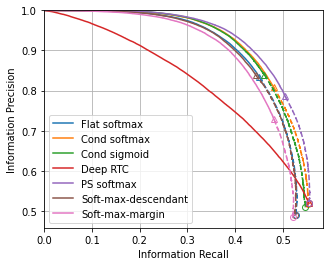

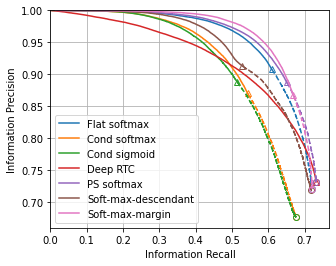

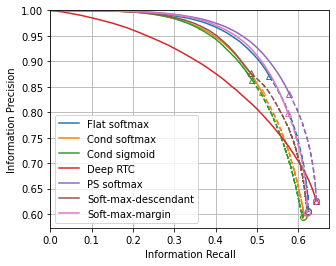

In [58]:
plot_metrics('train', 'unseen', 'info_recall', 'info_precision', save=True)
plt.show()
plot_metrics('train', 'seen', 'info_recall', 'info_precision', save=True)
plt.show()
plot_metrics('train', 'all', 'info_recall', 'info_precision', save=True)

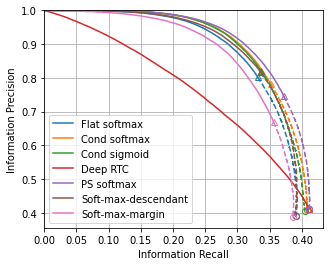

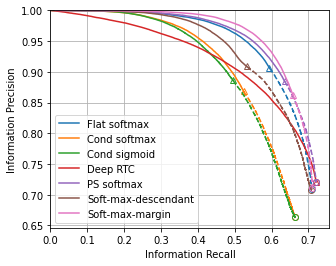

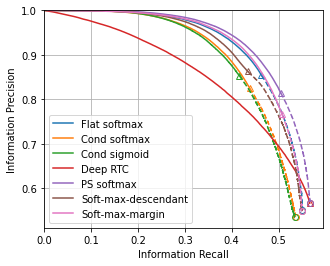

In [59]:
# Same for "full" tree (i.e. reward for not going to leaf node).

plot_metrics('full', 'unseen', 'info_recall', 'info_precision', save=True)
plt.show()
plot_metrics('full', 'seen', 'info_recall', 'info_precision', save=True)
plt.show()
plot_metrics('full', 'all', 'info_recall', 'info_precision', save=True)

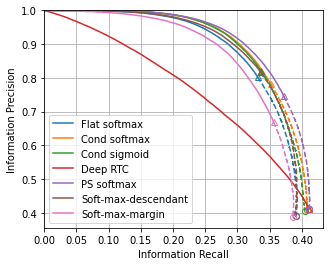

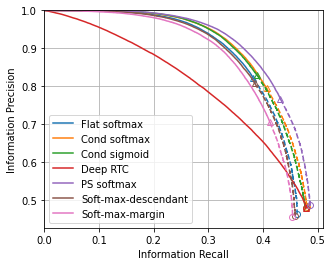

In [60]:
# Check the trade-off for unseen examples using metrics in the "train" and "trunc" subtrees.
# These give no penalty for predicting a leaf node under the nearest projected ancestor.
# (In fact, the prediction will be truncated at the ground-truth.)

plot_metrics('full', 'unseen', 'info_recall', 'info_precision', save=True)
plt.show()
plot_metrics('trunc', 'unseen', 'info_recall', 'info_precision', save=True)

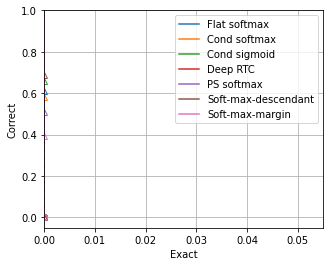

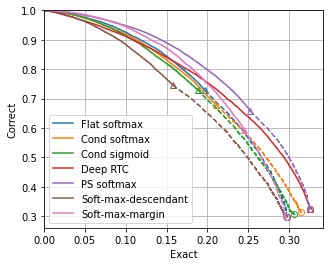

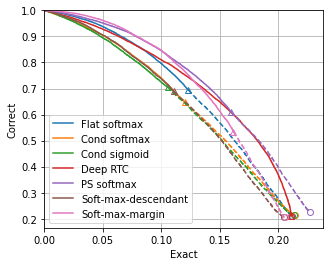

In [61]:
# Cannot plot correct-exact for unseen classes in full tree -- none will be exact.
# See how it looks in train/trunc trees.
# This requires the algorithm to predict the projected node, not a descendant.

plot_metrics('full', 'unseen', 'exact', 'correct', save=False)
plt.show()
plot_metrics('train', 'unseen', 'exact', 'correct', save=True)
plt.show()
plot_metrics('trunc', 'unseen', 'exact', 'correct', save=True)

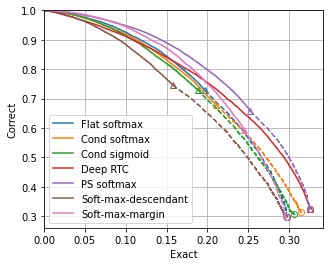

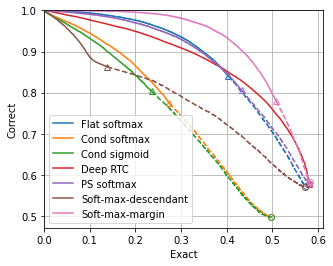

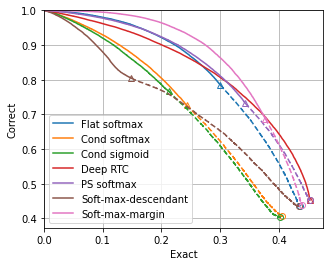

In [62]:
for subset_name in ['unseen', 'seen', 'all']:
    plot_metrics('train', subset_name, 'exact', 'correct', save=True)

In [55]:
# for subset_name in ['unseen', 'seen', 'all']:
#     plot_metrics('train', subset_name, x, y, save=True)